<a href="https://colab.research.google.com/github/t-nakatani/signate_stu22/blob/main/signate_stu_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
ROOT = "/content/drive/MyDrive/Colab Notebooks/signate/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://qiita.com/yamaru/items/63a342c844cff056a549

①データサイエンティスト（DS）  
②機械学習エンジニア（ML Engineer）  
③ソフトウェアエンジニア（Software Engineer）  
④コンサルタント（Consultant）   

In [2]:
jobdic = dict(zip([1, 2, 3, 4], ['DataScientist', 'ML Engineer', 'Software Engineer', 'Consultant']))
jobdic

{1: 'DataScientist', 2: 'ML Engineer', 3: 'Software Engineer', 4: 'Consultant'}

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
#学習用データと評価用データの読み込み
train = pd.read_csv(os.path.join(ROOT, "train.csv"))
test = pd.read_csv(os.path.join(ROOT, "test.csv"))

In [5]:
train

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4
...,...,...,...
1511,1511,"<li>Support detailed reporting, statistical an...",1
1512,1512,<li>Collaborate with teams to support the ML t...,2
1513,1513,<li> Work with executives and other business l...,1
1514,1514,<li>Leading design ideation sessions to ensure...,3


In [6]:
test

,id,description
0,1516,<li>Building decision-making models and propos...
1,1517,<li>Educate homeowners on the benefits of sola...
2,1518,"<li><span>Design, develop, document, and imple..."
3,1519,<li>Apply advanced technical expertise and ski...
4,1520,<li>Project manage and deliver against our roa...
...,...,...
1512,3028,<li> Manages the development of interface requ...
1513,3029,<li>Lead the implementation of new statistical...
1514,3030,<li>Configure Zuora to fulfill use cases</li><...
1515,3031,"<li>Gather, translate, and document stakeholde..."


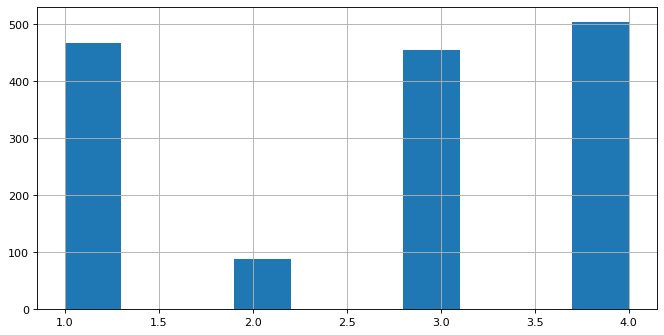

In [7]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
train.jobflag.hist()

In [8]:
test['jobflag'] = -1
combined = train.append(test, ignore_index=True)

In [9]:
import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_tag(text)
        # #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        # #単語長が3文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 3]
        #ステミング
        # clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        #単語同士をスペースでつなぎ, 文章に戻す
        # clean_text = ' '.join(clean_normalize)
        clean_text = ' '.join(clean_short_tokenized)
        
        clean_texts.append(clean_text)
    return clean_texts

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('',x)

train_cleaned = train.copy()
test_cleaned = test.copy()
train_cleaned['description'] = cleaning(train_cleaned['description'])
test_cleaned['description'] = cleaning(test_cleaned['description'])

In [10]:
train_cleaned.description[0]

'Develop cutting edge applications that perform superbly across platforms Work highly collaborative environment with cross functional teams projects ranging from weeks months length Maintain high standard quality creatively strategically problem solve throughout product delivery process able effectively communicate your work with both technical technical peersBe excited about technologies techniquesBuild solid front architectures that integrate easily with other systems technologiesWorking closely with other disciplines Back Design Have superior attention detail strong ability work required including cross browser cross platform displays performance'


*** Software Engineer ***



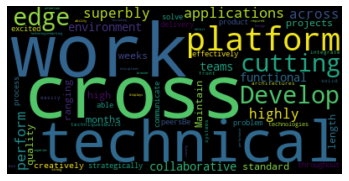


*** Consultant ***



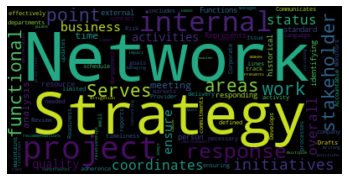


*** DataScientist ***



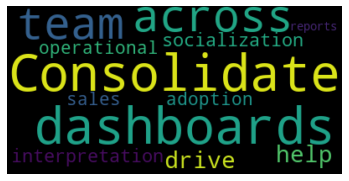

In [11]:
from wordcloud import WordCloud

## Visualize data
jobs_list = train_cleaned.jobflag.unique().tolist()
for job in jobs_list[:-1]:

    # Start with one review:
    text = train_cleaned[train_cleaned.jobflag == job].iloc[0].description
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",jobdic[int(job)],"***\n")
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [12]:
!pip install -q transformers==3

In [13]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt
from tqdm import tqdm

In [14]:
# Datasetの定義
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True,
      truncation=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [15]:
from sklearn.model_selection import train_test_split

y = pd.get_dummies(train_cleaned.jobflag).values
y_test = pd.get_dummies(test_cleaned.jobflag).values

X_train, X_val, y_train, y_val = train_test_split(train['description'].values, y, test_size=0.2,random_state=109) 

# Datasetの作成
max_len = 400
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = CreateDataset(X_train, y_train, tokenizer, max_len)
dataset_val = CreateDataset(X_val, y_val, tokenizer, max_len)
dataset_test = CreateDataset(test['description'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

ids: tensor([  101,  1026,  5622,  1028,  2009, 22139,  2007,  6612,  1998,  2313,
         2740,  5826,  2000,  2640,  1998, 16157,  9525,  6612,  3454,  1026,
         1013,  5622,  1028,  1026,  5622,  1028,  5452,  2004,  1037,  8025,
         1010,  9525,  6567,  6739,  1026,  1013,  5622,  1028,  1026,  5622,
         1028, 10580,  2844,  4807,  4813,  1006,  2119,  2517,  1998, 12064,
         1007,  1998,  1037,  3893,  1010,  5576,  1011,  8048,  7729,  1026,
         1013,  5622,  1028,  1026,  5622,  1028,  2060,  5704,  2004,  4137,
         1026,  1013,  5622,  1028,  1026,  1013, 17359,  1028,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   

In [16]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask)
    out = self.fc(self.drop(out))
    return out

In [17]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in tqdm(loader):
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in tqdm(dataloader_train):
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [18]:
# パラメータの設定
DROP_RATE = 0.1
OUTPUT_SIZE = 4
BATCH_SIZE = 8
NUM_EPOCHS = 20
LEARNING_RATE = 2e-6

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_val, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

100%|██████████| 152/152 [00:58<00:00,  2.62it/s]


epoch: 1, loss_train: 0.5126, accuracy_train: 0.4266, loss_valid: 0.5122, accuracy_valid: 0.4276, 86.4343sec


100%|██████████| 152/152 [00:54<00:00,  2.77it/s]


epoch: 2, loss_train: 0.4827, accuracy_train: 0.5635, loss_valid: 0.4807, accuracy_valid: 0.5822, 82.4779sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 3, loss_train: 0.4298, accuracy_train: 0.7063, loss_valid: 0.4346, accuracy_valid: 0.6711, 82.0667sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 4, loss_train: 0.3819, accuracy_train: 0.7310, loss_valid: 0.4002, accuracy_valid: 0.6678, 82.2110sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 5, loss_train: 0.3398, accuracy_train: 0.7698, loss_valid: 0.3727, accuracy_valid: 0.7039, 82.0047sec


100%|██████████| 152/152 [00:55<00:00,  2.72it/s]


epoch: 6, loss_train: 0.3122, accuracy_train: 0.7913, loss_valid: 0.3602, accuracy_valid: 0.7039, 83.6423sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 7, loss_train: 0.2817, accuracy_train: 0.8152, loss_valid: 0.3462, accuracy_valid: 0.7007, 81.9636sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 8, loss_train: 0.2565, accuracy_train: 0.8300, loss_valid: 0.3392, accuracy_valid: 0.7039, 81.9108sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 9, loss_train: 0.2398, accuracy_train: 0.8474, loss_valid: 0.3379, accuracy_valid: 0.6875, 81.9662sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 10, loss_train: 0.2192, accuracy_train: 0.8721, loss_valid: 0.3495, accuracy_valid: 0.7007, 82.0489sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 11, loss_train: 0.1947, accuracy_train: 0.8828, loss_valid: 0.3411, accuracy_valid: 0.7138, 82.1131sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 12, loss_train: 0.1777, accuracy_train: 0.8985, loss_valid: 0.3446, accuracy_valid: 0.7039, 82.0806sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 13, loss_train: 0.1645, accuracy_train: 0.9092, loss_valid: 0.3564, accuracy_valid: 0.6974, 82.0322sec


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


epoch: 14, loss_train: 0.1520, accuracy_train: 0.9092, loss_valid: 0.3540, accuracy_valid: 0.6974, 82.1084sec


 69%|██████▉   | 105/152 [00:39<00:17,  2.63it/s]


KeyboardInterrupt: ignored

In [21]:
torch.save(model, os.path.join(ROOT, 'v1.pth'))

In [20]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_val, device):.3f}')
# print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

RuntimeError: ignored

In [23]:
!pip install -q GPUtil
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 82% |


In [24]:
del ids, mask, labels

NameError: ignored

In [25]:
torch.cuda.empty()

AttributeError: ignored